In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./data/all-data.csv', names = ['labels','messages'],encoding='ISO-8859-1')

In [3]:
df.isnull().sum()

labels      0
messages    0
dtype: int64

In [4]:
df_copy = df.copy()
df_copy.head()

,labels,messages
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
def func(df_new):
    if df_new == 'neutral':
        return 0
    elif df_new == 'negative':
        return 1
    else:
        return 2
df_copy['target'] = df_copy.labels.apply(func)
df_copy.head()

,labels,messages,target
0,neutral,"According to Gran , the company has no plans t...",0
1,neutral,Technopolis plans to develop in stages an area...,0
2,negative,The international electronic industry company ...,1
3,positive,With the new production plant the company woul...,2
4,positive,According to the company 's updated strategy f...,2


In [6]:
# Maptplolib
import matplotlib.pyplot as plt 

# Seaborn
import seaborn as sns 

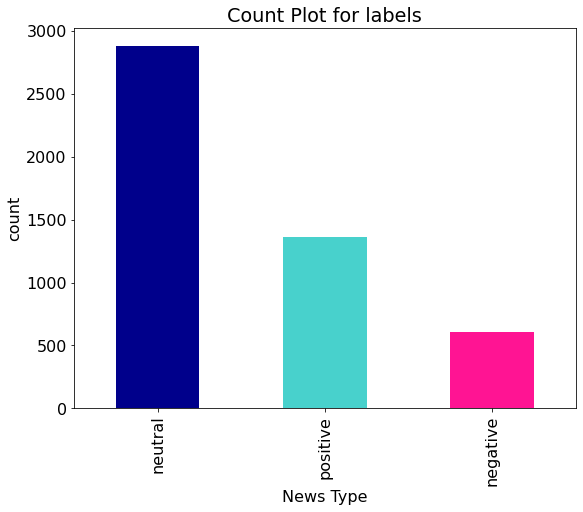

In [132]:
# Count plot for labels feature
plt.figure(figsize=(9,7))
df_copy.labels.value_counts().plot(kind='bar',color=['darkblue','mediumturquoise','deeppink'])
plt.xlabel("News Type")
plt.ylabel("count")
plt.title("Count Plot for labels");

In [8]:
#nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [9]:
import re

In [10]:
# Text preprocessing
corpous = list()

#Object for porterstem
ps = PorterStemmer()

for i in range(len(df_copy)):
    text = re.sub(r'[^a-zA-Z]',' ',df_copy.messages[i])
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if word not in set(stopwords.words('english'))]
    text = ' '.join(text)
    corpous.append(text)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpous).toarray()

In [12]:
# Dependent Feature
y = df_copy.target

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=43)

In [14]:
cv.get_feature_names_out()

array(['ab', 'ab sto', 'abb', ..., 'york', 'zinc', 'zone'], dtype=object)

In [15]:
# Scikit-learn
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [16]:
# Build Models

models = {
    MultinomialNB():'Multinomial Naive Bayes',
    LogisticRegression(max_iter=300):'Logistic Regression',
    SVC(C=1.0, kernel='linear', degree=3, gamma='auto'):"Support Vector Machine"
}
for m in models.keys():
    m.fit(X_train,y_train)

In [17]:
# Check Accuracy for each model
for model,name in models.items():
     print(f"Accuracy Score for {name} is : ",model.score(X_test,y_test)*100,"%")

Accuracy Score for Multinomial Naive Bayes is :  69.38144329896907 %
Accuracy Score for Logistic Regression is :  75.87628865979381 %
Accuracy Score for Support Vector Machine is :  71.75257731958763 %


## "Default" sentiment-analysis pipeline

Below we are going to start using the Huggingface library to predict the sentiment. The first attempt is to use the out-of-the-box "sentiment-analysis" pipeline with the default tuned distilbert model. This, however, doesn't match the needs of the project as we have three categories: 'positive', 'neutral', and 'negative'. The default distilbert model only has two available options. Nevertheless, the model scores particularly well on 'negative sentiments' and costs little to no time to code. 

In [18]:
#### Pretrained pipeline applied to data:

from transformers import pipeline

In [32]:
checkpoint = 'distilbert-base-uncased-finetuned-sst-2-english'
classifier = pipeline("sentiment-analysis", checkpoint)

In [33]:
df['sentiment_default'] = df.messages.apply(classifier)

In [34]:
classifier(df.messages[0])

[{'label': 'NEGATIVE', 'score': 0.9906287789344788}]

In [35]:
score_ls = [df.sentiment[i][0]['score'] for i in range(len(df.sentiment))]

In [37]:
df['score_default'] = score_ls

In [43]:
df.rename(columns={'sentiment':'sentiment_default'}, inplace=True)

In [48]:
df['pred_sentiment_default'] = [df.sentiment_default[i][0]['label'] for i in range(len(df.sentiment_default))]

In [49]:
df.pred_sentiment_default.unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

In [51]:
df['accurate_default'] = 0

In [56]:
for i, row in df.iterrows():
    accurate_val = 0
    if row.labels == row.pred_sentiment_default.lower():
        accurate_val = 1
    df.at[i,'accurate_default'] = accurate_val

In [57]:
df.head()

,labels,messages,sentiment_default,score_default,pred_sentiment_default,accurate_default
0,neutral,"According to Gran , the company has no plans t...","[{'label': 'NEGATIVE', 'score': 0.990628778934...",0.990629,NEGATIVE,0
1,neutral,Technopolis plans to develop in stages an area...,"[{'label': 'POSITIVE', 'score': 0.563786029815...",0.563786,POSITIVE,0
2,negative,The international electronic industry company ...,"[{'label': 'NEGATIVE', 'score': 0.967324018478...",0.967324,NEGATIVE,1
3,positive,With the new production plant the company woul...,"[{'label': 'POSITIVE', 'score': 0.997083485126...",0.997083,POSITIVE,1
4,positive,According to the company 's updated strategy f...,"[{'label': 'POSITIVE', 'score': 0.861706733703...",0.861707,POSITIVE,1


In [87]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['font.size'] =16

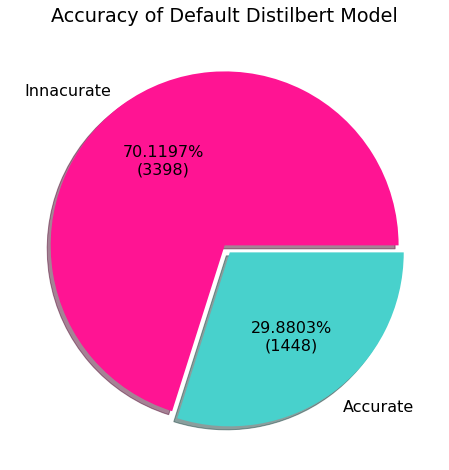

In [129]:
## Check how many predictions the pipeline accurately predicted the sentiment
total= len(df.accurate_default)
explode=[0,.05]
plt.pie(df.accurate_default.value_counts(), labels=['Innacurate', 'Accurate'], explode=explode,colors=['deeppink','mediumturquoise'], 
        shadow=True, autopct=lambda p: '{:.4f}%\n({:.0f})'.format(p, total*p/100))
plt.title('Accuracy of Default Distilbert Model')
plt.show()

In [ ]:
df.labels.value_counts()

The pipeline misidentified  3398 of 4846, however, with 2879 neutral sentiments of 4846, this is unsurprising.

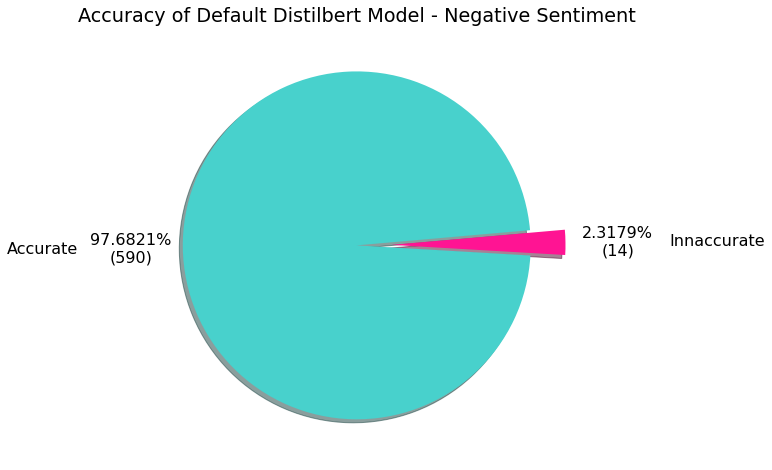

In [204]:
total= len(df[df.labels=='negative'])
explode=[0,.2]
plt.pie(df[df.labels=='negative'].accurate_default.value_counts(), labels=['Accurate', 'Innaccurate'],
        explode=explode, shadow=True, autopct=lambda p: '{:.4f}%\n({:.0f})'.format(p, total*p/100),
        pctdistance=1.3, labeldistance=1.6, colors=['mediumturquoise','deeppink'], startangle=5)
plt.title('Accuracy of Default Distilbert Model - Negative Sentiment')
plt.show()

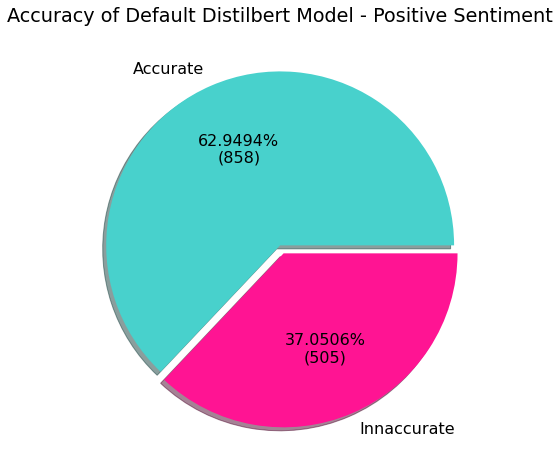

In [128]:
total= len(df[df.labels=='positive'])
explode=[0,.05]
plt.pie(df[df.labels=='positive'].accurate_default.value_counts(), labels=['Accurate', 'Innaccurate'],
        explode=explode, shadow=True, autopct=lambda p: '{:.4f}%\n({:.0f})'.format(p, total*p/100),
        colors=['mediumturquoise','deeppink'])
plt.title('Accuracy of Default Distilbert Model - Positive Sentiment')
plt.show()

The sentiment pipeline does a relatively decent job detecting negative sentiment, with a 97 % accuracy; on the other hand, it misses positive scores at a significantly higher rate, with a 63% accuracy. 

## FinancialBERT for Sentiment Analysis

FinancialBERT is a BERT model pre-trained on a large corpora of financial texts. The purpose is to enhance financial NLP research and practice in financial domain, hoping that financial practitioners and researchers can benefit from this model without the necessity of the significant computational resources required to train the model.

The model was fine-tuned for Sentiment Analysis task on Financial PhraseBank dataset. Experiments show that this model outperforms the general BERT and other financial domain-specific models.

More details on FinancialBERT's pre-training process can be found at: https://www.researchgate.net/publication/358284785_FinancialBERT_-_A_Pretrained_Language_Model_for_Financial_Text_Mining

Training data
FinancialBERT model was fine-tuned on Financial PhraseBank, a dataset consisting of 4840 Financial News categorised by sentiment (negative, neutral, positive).

Fine-tuning hyper-parameters
learning_rate = 2e-5
batch_size = 32
max_seq_length = 512
num_train_epochs = 5
Evaluation metrics
The evaluation metrics used are: Precision, Recall and F1-score. The following is the classification report on the test set.

In [149]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [150]:
test_mod = nlp(df_copy.loc[2, "messages"], )

In [151]:
test_mod

[{'label': 'negative', 'score': 0.9996824264526367}]

In [152]:
#create a new column which corresponds to the new model's sentiment prediction
df['sentiment_finbert'] = df['messages'].apply(nlp)

In [153]:
df.head(2)

,labels,messages,sentiment_default,score_default,pred_sentiment_default,accurate_default,sentiment_finbert
0,neutral,"According to Gran , the company has no plans t...","[{'label': 'NEGATIVE', 'score': 0.990628778934...",0.990629,NEGATIVE,0,"[{'label': 'neutral', 'score': 0.9888190627098..."
1,neutral,Technopolis plans to develop in stages an area...,"[{'label': 'POSITIVE', 'score': 0.563786029815...",0.563786,POSITIVE,0,"[{'label': 'neutral', 'score': 0.9998527765274..."
2,negative,The international electronic industry company ...,"[{'label': 'NEGATIVE', 'score': 0.967324018478...",0.967324,NEGATIVE,1,"[{'label': 'negative', 'score': 0.999682426452..."
3,positive,With the new production plant the company woul...,"[{'label': 'POSITIVE', 'score': 0.997083485126...",0.997083,POSITIVE,1,"[{'label': 'positive', 'score': 0.999854922294..."
4,positive,According to the company 's updated strategy f...,"[{'label': 'POSITIVE', 'score': 0.861706733703...",0.861707,POSITIVE,1,"[{'label': 'positive', 'score': 0.999766051769..."


In [154]:
#extract a list of the sentiments from the 
df['score_finbert'] = [df.sentiment_finbert[i][0]['score'] for i in range(len(df.sentiment_finbert))]

#extract the predicted label
df['pred_sentiment_finbert'] = [df.sentiment_finbert[i][0]['label'] for i in range(len(df.sentiment_finbert))]

#create a dummy column to iterate over for bertweet predictions
df['accurate_finbert'] = 0

#score
for i, row in df.iterrows():
    accurate_val = 0
    if row.labels == row.pred_sentiment_finbert.lower():
        accurate_val = 1
    df.at[i,'accurate_finbert'] = accurate_val

In [155]:
df.head()

,labels,messages,sentiment_default,score_default,pred_sentiment_default,accurate_default,sentiment_finbert,score_finbert,pred_sentiment_finbert,accurate_finbert
0,neutral,"According to Gran , the company has no plans t...","[{'label': 'NEGATIVE', 'score': 0.990628778934...",0.990629,NEGATIVE,0,"[{'label': 'neutral', 'score': 0.9888190627098...",0.988819,neutral,1
1,neutral,Technopolis plans to develop in stages an area...,"[{'label': 'POSITIVE', 'score': 0.563786029815...",0.563786,POSITIVE,0,"[{'label': 'neutral', 'score': 0.9998527765274...",0.999853,neutral,1
2,negative,The international electronic industry company ...,"[{'label': 'NEGATIVE', 'score': 0.967324018478...",0.967324,NEGATIVE,1,"[{'label': 'negative', 'score': 0.999682426452...",0.999682,negative,1
3,positive,With the new production plant the company woul...,"[{'label': 'POSITIVE', 'score': 0.997083485126...",0.997083,POSITIVE,1,"[{'label': 'positive', 'score': 0.999854922294...",0.999855,positive,1
4,positive,According to the company 's updated strategy f...,"[{'label': 'POSITIVE', 'score': 0.861706733703...",0.861707,POSITIVE,1,"[{'label': 'positive', 'score': 0.999766051769...",0.999766,positive,1


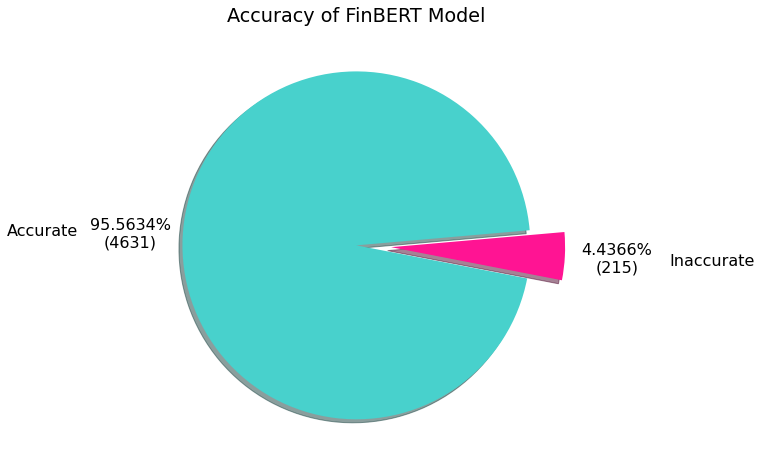

In [193]:
## Check how many predictions the finbert pipeline accurately predicted the sentiment
total= len(df.accurate_finbert)
explode=[0,.2]
plt.pie(df.accurate_finbert.value_counts(), labels=['Accurate', 'Inaccurate'], explode=explode,colors=['mediumturquoise','deeppink'], 
        shadow=True, autopct=lambda p: '{:.4f}%\n({:.0f})'.format(p, total*p/100),
       pctdistance=1.3, labeldistance=1.6, startangle=5)
plt.title('Accuracy of FinBERT Model')
plt.show()

In [157]:
df.accurate_finbert.value_counts()

1    4631
0     215
Name: accurate_finbert, dtype: int64

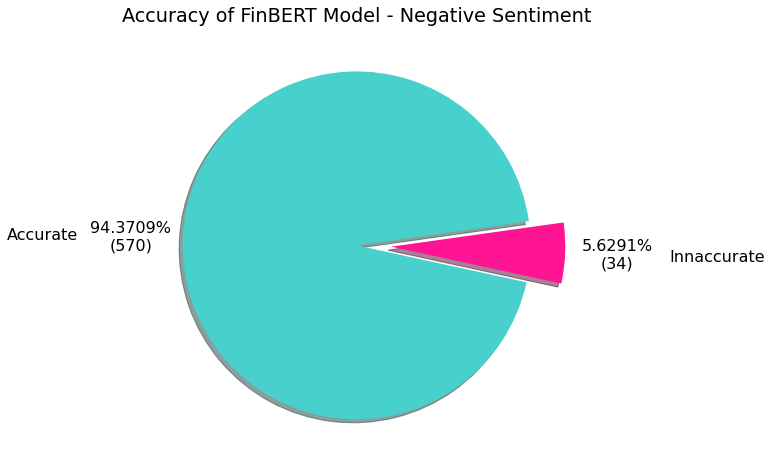

In [202]:
total= len(df[df.labels=='negative'])
explode=[0,.2]
plt.pie(df[df.labels=='negative'].accurate_finbert.value_counts(), labels=['Accurate', 'Innaccurate'],
        explode=explode, shadow=True, autopct=lambda p: '{:.4f}%\n({:.0f})'.format(p, total*p/100),
        pctdistance=1.3, labeldistance=1.6, colors=['mediumturquoise','deeppink'], startangle=8)
plt.title('Accuracy of FinBERT Model - Negative Sentiment')
plt.show()

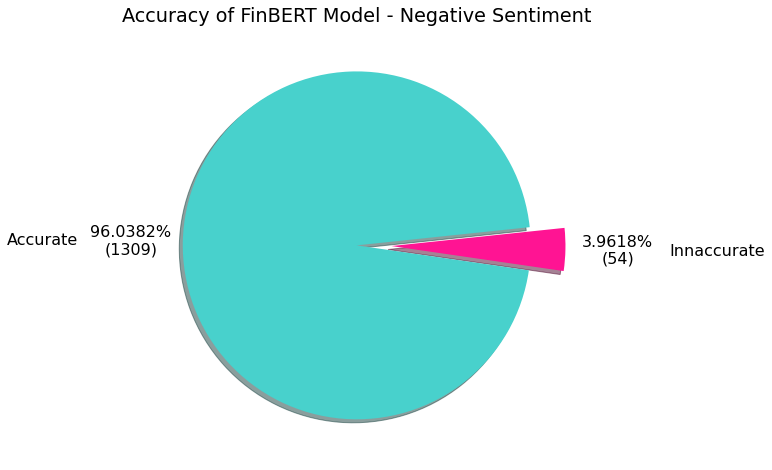

In [197]:
total= len(df[df.labels=='positive'])
explode=[0,.2]
plt.pie(df[df.labels=='positive'].accurate_finbert.value_counts(), labels=['Accurate', 'Innaccurate'],
        explode=explode, shadow=True, autopct=lambda p: '{:.4f}%\n({:.0f})'.format(p, total*p/100),
        pctdistance=1.3, labeldistance=1.6, colors=['mediumturquoise','deeppink'], startangle=6)
plt.title('Accuracy of FinBERT Model - Negative Sentiment')
plt.show()

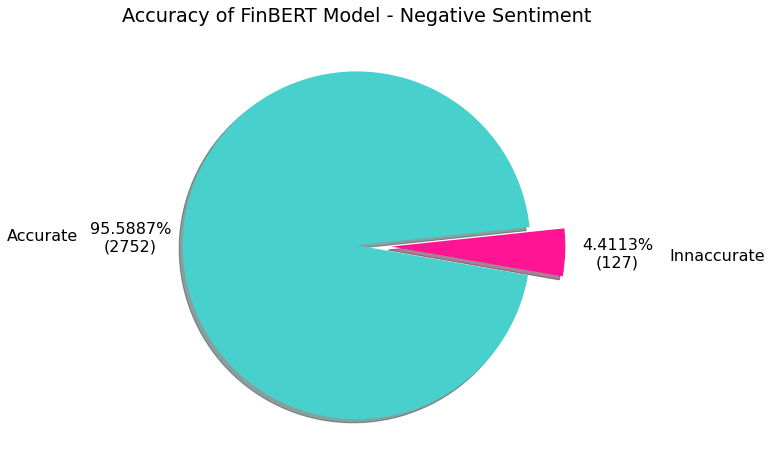

In [198]:
total= len(df[df.labels=='neutral'])
explode=[0,.2]
plt.pie(df[df.labels=='neutral'].accurate_finbert.value_counts(), labels=['Accurate', 'Innaccurate'],
        explode=explode, shadow=True, autopct=lambda p: '{:.4f}%\n({:.0f})'.format(p, total*p/100),
        pctdistance=1.3, labeldistance=1.6, colors=['mediumturquoise','deeppink'], startangle=6)
plt.title('Accuracy of FinBERT Model - Negative Sentiment')
plt.show()

**Results:**

<br>
Default Distilbert performs better on negative sentiments, which suggests it's a better model generally speaking; even despite lacking a 'neutral' classifier. Overall performance is clearly better due to the FinBERT model having a neutral classifer (Default Distilbert is only 28% accurate on the text data, while FinBERT is 95% accurate). The FinBERT model performed worst on a negative sentiment (with 5.5 % innacurate suggestions) compared to the 2.3% innacruate suggestions of Default DistilBERT.
